In [10]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from imutils import face_utils
font = cv2.FONT_HERSHEY_SIMPLEX

In [2]:
import os

def get_files(path):
    return os.listdir(path)

cascPath = "/Users/abdulrehman/opt/anaconda3/envs/Face-Detection/lib/python3.6/site-packages/cv2/data/haarcascade_frontalface_default.xml"

def return_bbx(image):
    faceCascade = cv2.CascadeClassifier(cascPath)
    faces = faceCascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, flags=cv2.CASCADE_SCALE_IMAGE)
    return faces

In [3]:
Dataset_path = '/Users/abdulrehman/Desktop/SML Project/FacesInTheWild/'

Celebs = pd.read_csv(Dataset_path+'lfw_allnames.csv')
Celebs = Celebs[Celebs['images']>50]
Celebs

,name,images
373,Ariel_Sharon,77
1047,Colin_Powell,236
1404,Donald_Rumsfeld,121
1871,George_W_Bush,530
1892,Gerhard_Schroeder,109
2175,Hugo_Chavez,71
2288,Jacques_Chirac,52
2468,Jean_Chretien,55
2682,John_Ashcroft,53
2941,Junichiro_Koizumi,60


In [4]:
X = []
Y = []

for _, [name,__] in Celebs.iterrows():
    celeb_path = Dataset_path+'lfw-deepfunneled/'+name+'/'
    
    images_paths = get_files(celeb_path)
    for image_path in images_paths:
        image = cv2.imread(celeb_path+image_path,1)
        faces = return_bbx(image)
        if len(faces) == 1:
            (x,y,w,h) = faces[0]
            cropped = image[x:x+w, y:y+h]
            dim = (64, 64)
            resized = cv2.resize(cropped, dim, interpolation = cv2.INTER_AREA)
            image = np.array(resized).astype("float32")
            X.append(image)
            Y.append(name)



In [70]:
X_data = np.array(X)
Y_data = np.array(Y)

In [71]:
from collections import Counter

Counter(Y_data)

Counter({'Ariel_Sharon': 70,
         'Colin_Powell': 213,
         'Donald_Rumsfeld': 109,
         'George_W_Bush': 480,
         'Gerhard_Schroeder': 106,
         'Hugo_Chavez': 67,
         'Jacques_Chirac': 51,
         'Jean_Chretien': 51,
         'John_Ashcroft': 47,
         'Junichiro_Koizumi': 51,
         'Serena_Williams': 48,
         'Tony_Blair': 138})

In [72]:
from imblearn.under_sampling import NearMiss

X_data_reshaped = X_data.reshape(X_data.shape[0], X_data.shape[1] * X_data.shape[2] * X_data.shape[3])
undersample = NearMiss(version=1)
X_resampled, Y_resampled = undersample.fit_resample(X_data_reshaped,Y_data)
# X_data = X_resampled.reshape(X_resampled.shape[0], X_data.shape[1], X_data.shape[2], X_data.shape[3])
Y_data = Y_resampled
counter = Counter(Y_data)
print(counter)

del X_data_reshaped
del undersample
# del X_resampled
del Y_resampled
del counter

Counter({'Ariel_Sharon': 47, 'Colin_Powell': 47, 'Donald_Rumsfeld': 47, 'George_W_Bush': 47, 'Gerhard_Schroeder': 47, 'Hugo_Chavez': 47, 'Jacques_Chirac': 47, 'Jean_Chretien': 47, 'John_Ashcroft': 47, 'Junichiro_Koizumi': 47, 'Serena_Williams': 47, 'Tony_Blair': 47})


In [73]:
a = Y_data
n_classes = len(set(a))
n_classes

12

In [74]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

Y_data = enc.fit_transform(Y_data.reshape(-1,1))

In [75]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler(feature_range=(0, 1))
X_resampled = scaler.fit_transform(X_resampled)
X_data = X_resampled.reshape(X_resampled.shape[0], X_data.shape[1],
                             X_data.shape[2], X_data.shape[3])


In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=0.9, random_state = 0)


In [129]:
from keras.applications import VGG16
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
# from keras.layers.advanced_activations import LeakyReLU

num_classes = 12

vgg = VGG16(weights = 'imagenet',include_top = False, input_shape = (64,64,3))

for layer in vgg.layers:
    layer.trainable = False

out = [layer.output for layer in vgg.layers][-7]

hidden_layer = out
hidden_layer = Flatten()(hidden_layer)
hidden_layer = Dropout(0.5)(hidden_layer)
hidden_layer = Dense(900, kernel_regularizer=l2(1e-2))(hidden_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Activation('relu')(hidden_layer)
# hidden_layer = Dropout(0.5)(hidden_layer)
# hidden_layer = Dense(512, kernel_regularizer=l2(1e-3))(hidden_layer)
# hidden_layer = BatchNormalization()(hidden_layer)
# hidden_layer = Dropout(0.5)(hidden_layer)
# hidden_layer = Dense(128, kernel_regularizer=l2(1e-3))(hidden_layer)
# hidden_layer = BatchNormalization()(hidden_layer)
# hidden_layer = Activation('relu')(hidden_layer)
out = Dense(n_classes, activation='softmax')(hidden_layer)

model = Model(inputs = vgg.input, outputs = out)

model.summary()

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)     

In [130]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

epochs=25
batch_size=16

checkpoint = ModelCheckpoint("face_recog_vgg.h5", monitor="val_accuracy", mode = "max",
                             save_best_only = True, verbose = 1)

callbacks = [checkpoint]

history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    verbose = 1, epochs = epochs, batch_size = batch_size,
                   callbacks = callbacks)

Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 17.5368 - accuracy: 0.5483
Epoch 00001: val_accuracy improved from -inf to 0.68421, saving model to face_recog_vgg.h5
32/32 [==============================] - 14s 431ms/step - loss: 17.5368 - accuracy: 0.5483 - val_loss: 15.9688 - val_accuracy: 0.6842
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 14.2681 - accuracy: 0.9645
Epoch 00002: val_accuracy improved from 0.68421 to 0.80702, saving model to face_recog_vgg.h5
32/32 [==============================] - 12s 378ms/step - loss: 14.2681 - accuracy: 0.9645 - val_loss: 13.6342 - val_accuracy: 0.8070
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 12.5494 - accuracy: 0.9862
Epoch 00003: val_accuracy improved from 0.80702 to 0.92982, saving model to face_recog_vgg.h5
32/32 [==============================] - 12s 371ms/step - loss: 12.5494 - accuracy: 0.9862 - val_loss: 11.9869 - val_accuracy: 0.9298
Epoch 4/25
32/32 [================

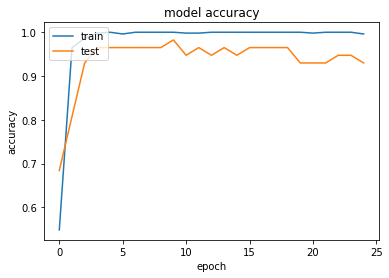

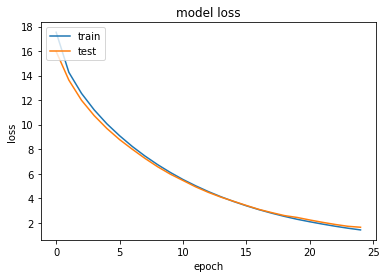

In [131]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [134]:
from keras.models import load_model

classifier = load_model('face_recog_vgg.h5')

print("Evaluate on test data")
results = classifier.evaluate(X_test, y_test, batch_size=batch_size)
print(" test acc: ",results[1], " test loss: ", results[0])

Evaluate on test data
4/4 [==============================] - 0s 110ms/step - loss: 5.9650 - accuracy: 0.9825
 test acc:  0.9824561476707458  test loss:  5.964965343475342
